# Assign land cover to FPA FOD wildfires
- Use MODIS land cover data for the best guess of land cover type burned by a given FPA-FOD wildfire. 
- Assume spherical burn scar around FPA FOD fire lat lon location. Use that scar to estimate the types of land cover burned by a fire. 
- The land cover data are 0.5 x 0.5 km, so many of the fires in FPA FOD will essentially have point estimate land cover types given the size of the grid. 


Consider impact of going from a burn area estimate on a slope to a flat world for the modis burn area. This may require using overlap only for assigning proportions of the assigned burn area value.  

In [1]:
area_of_modis_cell = (0.5*1000.)**2
print str(area_of_modis_cell) + " m2: area of 0.5 x 0.5 degree MODIS grid cell at equator"

m2_per_acre = 4046.86 # m2/acres
acres_per_cell = area_of_modis_cell / m2_per_acre

print str(acres_per_cell) + ": acres per modis land cover grid cell"

250000.0 m2: area of 0.5 x 0.5 degree MODIS grid cell at equator
61.7762907538: acres per modis land cover grid cell


| Value        | Label          |
| -------------|:-------------|
|0 | Water|
|1|Evergreen Needleleaf forest|
|2|Evergreen Broadleaf forest|
|3|Deciduous Needleleaf forest|
|4|Deciduous Broadleaf forest|
|5|Mixed forest|
|6|Closed shrublands|
|7|Open shrublands|
|8|Woody savannas|
|9|Savannas|
|10|Grasslands|
|11|Permanent wetlands|
|12|Croplands|
|13|Urban and built-up|
|14|Cropland/Natural vegetation mosaic|
|15|Snow and ice|
|16|Barren or sparsely vegetated|

In [2]:
# Make that nice table into a dictionary that can be called. 
LC_dict = {0:"Water",
           1:"Evergreen Needleleaf forest",
           2:"Evergreen Broadleaf forest",
           3:"Deciduous Needleleaf forest",
           4:"Deciduous Broadleaf forest",
           5:"Mixed forest",
           6:"Closed shrublands",
           7:"Open shrublands",
           8:"Woody savannas",
           9:"Savannas",
           10:"Grasslands",
           11:"Permanent wetlands",
           12:"Croplands",
           13:"Urban and built-up",
           14:"Cropland/Natural vegetation mosaic",
           15:"Snow and ice",
           16:"Barren or sparsely vegetated"
          }

This means that the 0.5 km modis land cover can resolve sub wildfire burn scar land cover types, i.e. it is and should be possible to estimate the different land covers that are consumed by large wildfires. 

### Get the MODIS land cover data loaded into the workspace

In [3]:
import gdal # For working with the Geotiff. 
import os
import numpy as np
from matplotlib import pylab as plt
# http://geopandas.org/set_operations.html
from shapely.geometry import Polygon, Point
import geopandas
import pandas as pd

%matplotlib inline

dataDir = os.path.join("..", "..", "metSpreadData", "GIS")
f = os.path.join(dataDir, "LCType.tif")
gtif = gdal.Open( f )
LC_data = np.array(gtif.GetRasterBand(1).ReadAsArray())

print "Shape of the LC data:"
print LC_data.shape

# Get the coordinates 
width  = gtif.RasterXSize
height = gtif.RasterYSize
gt     = gtif.GetGeoTransform()

print width
print height
print "gtiff.GetGeoTransform() returned attributes"
print gt

#print "working on getting unique values in large 2D array...."
#print "Unique land cover values array: " + str(np.unique(LC_data))


Shape of the LC data:
(43200, 86400)
86400
43200
gtiff.GetGeoTransform() returned attributes
(-179.9999999979966, 0.004166666666666719, 0.0, 89.9999999919177, 0.0, -0.004166666666666719)


Get the coordinates of these pixels. Make sure that the coordinate structure (lat lon) arrays represent pixel centers. 

In [4]:
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3] 

print "Printing the coordinate limits as defined here:"
print "minx " + str(minx)
print "maxx " + str(maxx)
print "miny " + str(miny)
print "maxy " + str(maxy)

# Logically speaking, the data should span the length of the min and max coord values
# by the number of dim size. 
# TODO: Read the documentation to understand if these coords represent grid centers or 
# TODO: corners. 
LC_x = np.linspace(minx, maxx, LC_data.shape[1])
LC_y = np.linspace(maxy, miny, LC_data.shape[0])

Printing the coordinate limits as defined here:
minx -179.999999998
maxx 180.000000002
miny -90.0000000081
maxy 89.9999999919


## Make up fire location and test functionality of overlap methods below
#### Extensive testing still required
- Limit of very small fire
- Limit of very large fire (Implement geographic reference system)
-- http://geopandas.org/data_structures.html

In [51]:
# Read in the FPA FOD data
fpa_fod_file = os.path.join("..","Data","Fire","FPA_FOD", "FPA_FOD_1992_2015_eco.csv")
FPA_FOD = pd.read_csv(fpa_fod_file)
nFires = FPA_FOD.shape[0]

# Add land cover types as new columns 
for newrow in LC_dict.values():
    FPA_FOD[newrow] = (np.zeros(nFires)-1)

In [39]:
# hypothetical wildfire with size specified in acres. These will come from FPA FOD.
# #rainier_summit = [-121.7586, 46.85449]
fire_size_acres = 100000#61.7
fire_lon = -105.9#-81.33#-122.341072    #-119.176894  
fire_lat = 40.4879#47.599264      # 46.487794 

# In order to subset the land cover grid around a fire's location, need to 
# know the width of the grid in deg units. Use max observed in the data, as
# it is ok to make a slightly larger than needed area to check fire overlap.
LC_grid_dx = np.max(np.diff(LC_x))
LC_grid_dy = np.max(np.abs(np.diff(LC_y)))

print "----------------------------------------"
print "Grid spacing in x " + str(LC_grid_dx)
print "Grid spacing in y " + str(LC_grid_dy)

# Need to get from acres to SI units so we can think about what this
# size fire means in terms of a lat lon grid
m2_per_acre = 4046.86
fire_area_m2 = fire_size_acres * m2_per_acre

print "----------------------------------------"
print "Fire location and area:"
print fire_lon
print fire_lat
print fire_area_m2

# Assuming the fire area is a circle, calculate radius from area
# NOTE: Area needs to be in m**2
fire_rad_m = np.sqrt(fire_area_m2/np.pi)

# Subset the LC grid needed to encompas this circle. Create spatial extents
# using local meters per degree values in the x and y directions. 
# NOTE: The coords of LC_grid units are degrees lon and lat. 
m_per_deg_lat = (111.*1000.) # ~111 km per deg and 1000 meter per km
m_per_deg_lon = (111.*1000.) * np.cos(fire_lat * np.pi/180.) # 0 at pole, 90 deg N. 

# Fire radius needs to be expressed in terms of degrees for polygon creation
fire_rad_deg =  fire_rad_m / m_per_deg_lat 
print "fire_rad_deg: " + str(fire_rad_deg)

# Establish LC_grid extent where overlap calculations are needed
# Add one LC_grid box width to make sure the circle is covered for very 
# small wildfires.
minLat = fire_lat - (fire_rad_deg + LC_grid_dy) 
maxLat = fire_lat + (fire_rad_deg + LC_grid_dy)
minLon = fire_lon - (fire_rad_deg + LC_grid_dy)
maxLon = fire_lon + (fire_rad_deg + LC_grid_dy)

# Mask these extends on the LC coordinates and grid
lonIndex = np.where( ( (LC_x >= minLon) & (LC_x <= maxLon)) )[0]
latIndex = np.where( ( (LC_y >= minLat) & (LC_y <= maxLat) ) )[0]
LC_x_subset = LC_x[lonIndex]
LC_y_subset = LC_y[latIndex]
LC_subset   = LC_data[np.ix_(latIndex, lonIndex)]

# Get a local dx dy for this subset of grid boxes
LC_subset_dx = np.max(np.diff(LC_x_subset))
LC_subset_dy = np.max(np.abs(np.diff(LC_y_subset)))

print LC_subset

----------------------------------------
Grid spacing in x 0.004166714892562595
Grid spacing in y 0.004166763119542338
----------------------------------------
Fire location and area:
-105.9
40.4879
404686000.0
fire_rad_deg: 0.10224949577590847
[[ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 ...
 [ 1  1  1 ... 10 10 10]
 [ 1  1  1 ... 10 10 10]
 [ 1  1  1 ... 10 10 10]]


### Make Polygons, determine overlap

In [40]:
# Make fire a circle shapely polygon object 
fire_poly = Point(fire_lon, fire_lat).buffer(fire_rad_deg)

print "---------------------------------------------------"
print "Initial Fire Circle Area: " + str(fire_poly.area)
print "---------------------------------------------------"

# NOTE: The definition of the polygon corners depends on whether the LC_grid_coords
# NOTE: represent grid corners or grid centers. 
# TODO: Retain land cover information here. 
ncolumn = len(LC_x_subset)
nrow = len(LC_y_subset)
print "ncolumn: " + str(ncolumn)
print "nrow: " + str(nrow)

# NOTE: This will break near edges of LC_subset. 
count = 0
LC_grid_polygon_list = [None] * (ncolumn * nrow)
LC_cover = [None] * (ncolumn * nrow)
print "length of LC_cover list: " + str(len(LC_cover))
for i in range(ncolumn):
    for j in range(nrow):
        
        # Get land cover for this grid box
        LC_cover[count] = LC_subset[j, i]
        
        # where coords are top left of pixels. 
        x0 = LC_x_subset[i] 
        x1 = LC_x_subset[i] + LC_subset_dx 
        y0 = LC_y_subset[j]
        y1 = LC_y_subset[j] - LC_subset_dy 
        LC_grid_polygon_list[count]  = Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)])
        count = count + 1 # Advance the count of created polygons

print "For loop complete"
        
# Create GeoSeries of local grid and fire
grid_polys = geopandas.GeoSeries(LC_grid_polygon_list)
fire_polys = geopandas.GeoSeries(fire_poly)

# Setup geographic coordinate system for fire and grid boxes to live on.
crs_assign = {'init':'+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'}
grid_polys.crs = crs_assign
fire_polys.crs = crs_assign

# Create GeoDataFrame, which have desirable properties and methods
grid_polys_df = geopandas.GeoDataFrame({'geometry': grid_polys, 'grid_LC_val':LC_cover})
fire_polys_df = geopandas.GeoDataFrame({'geometry': fire_polys, 'Fire':"FireName"})

---------------------------------------------------
Initial Fire Circle Area: 0.0327924870822
---------------------------------------------------
ncolumn: 51
nrow: 51
length of LC_cover list: 2601
For loop complete


### Perform the intersection of the polygons

In [41]:
# Returns only the geometries that are contained by both GeoDataFrames
# This is an expensive operation. 
res_intersection = geopandas.overlay(grid_polys_df, fire_polys_df, how='intersection')

# Add the overlapping area to this intersection dataframe 
res_intersection['grid_overlap_fraction'] = pd.Series(res_intersection.area/fire_poly.area, 
                                                      index=res_intersection.index)

# Append Percent Overlap information to the intersection DataFrame 
res_intersection['percent_of_fire_area'] = pd.Series(res_intersection.area/fire_poly.area*100.,
                                                     index=res_intersection.index)

# Attributes to append to FPA FOD dataframe 
percent_of_fire_area_overlaped = np.sum(res_intersection['percent_of_fire_area'])

# Calculate the burn area from each overlapped land cover type
LC_types = LC_dict.values()
nLC = len(LC_types)
percent_area = np.zeros(nLC)
LC_area_for_fire = np.zeros(nLC) 
for LC_number in LC_dict.keys():
    mask = LC_number == res_intersection["grid_LC_val"]
    percent_area[LC_number]     = np.sum(res_intersection["grid_overlap_fraction"][mask])
    LC_area_for_fire[LC_number] = percent_area[LC_number] * fire_size_acres
    
delta_area = fire_size_acres - np.sum(LC_area_for_fire)

# Append these information to FPA FOD wildfires. 

## Plot results of overlapping analysis

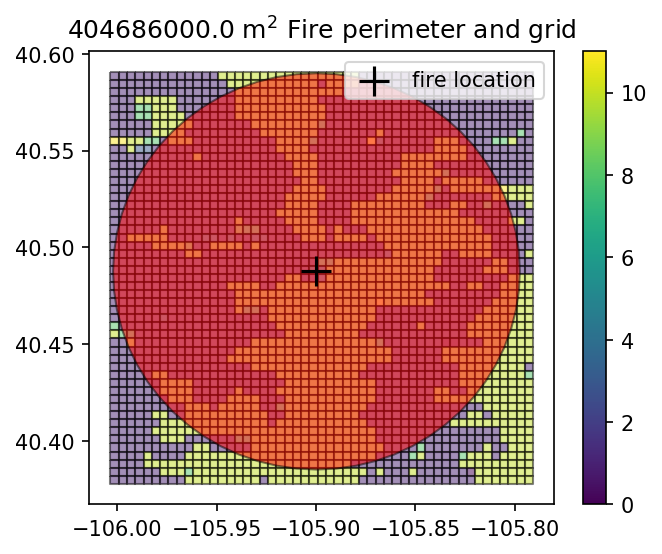

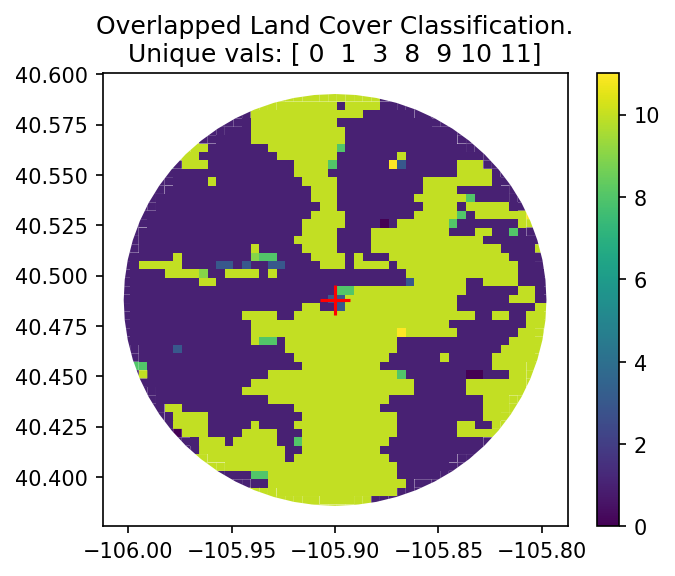

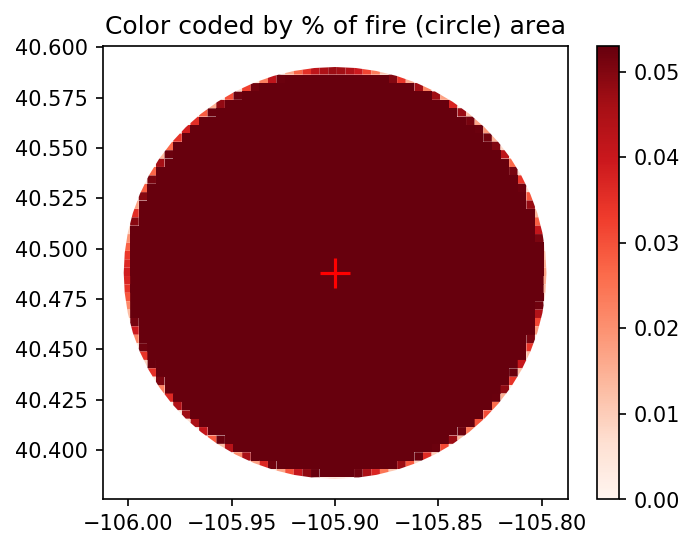

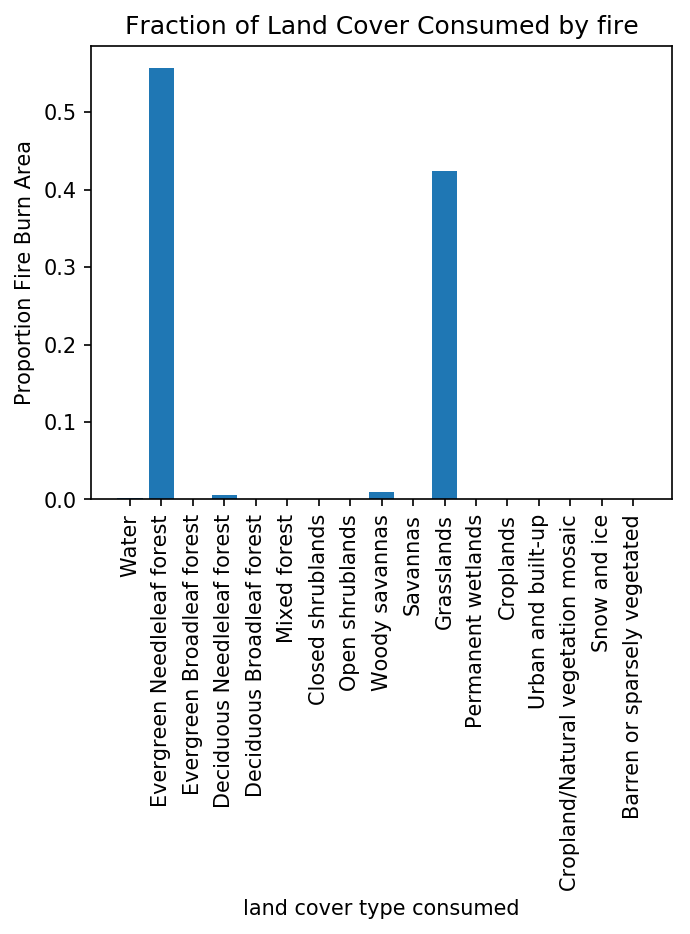

Max percent of circle area for a single gridcell: 0.05294418169689449
Min percent of circle area for a single gridcell: 3.07918687640621e-25
Sum of all percent overlap values: 99.9999999999994


,grid_LC_val,Fire,geometry,grid_overlap_fraction,percent_of_fire_area
0,10,FireName,POLYGON ((-105.8741420598251 40.48218707958115...,9.028376e-16,9.028376e-14
1,10,FireName,POLYGON ((-105.8699753449326 40.48218707958115...,5.294418e-04,5.294418e-02
2,1,FireName,POLYGON ((-105.9991435066011 40.48218707958115...,9.028376e-16,9.028376e-14
3,1,FireName,POLYGON ((-105.9949767917086 40.48218707958115...,5.294418e-04,5.294418e-02
4,1,FireName,POLYGON ((-105.9241426385355 40.48218707958115...,9.028376e-16,9.028376e-14
5,1,FireName,"POLYGON ((-105.919975923643 40.48218707958115,...",5.294418e-04,5.294418e-02
6,1,FireName,POLYGON ((-105.9866433619235 40.48218707958115...,9.028376e-16,9.028376e-14
7,1,FireName,"POLYGON ((-105.982476647031 40.48218707958115,...",5.294418e-04,5.294418e-02
8,10,FireName,"POLYGON ((-105.803307906652 40.48218707958115,...",9.028376e-16,9.028376e-14
9,10,FireName,POLYGON ((-105.7991411917595 40.48218707958115...,5.294418e-04,5.294418e-02


In [42]:
# Show the geodataframe rectangles and fire circle
fig, ax = plt.subplots(1, 1, dpi=150, figsize=(5,4))
grid_polys_df.plot(ax=ax, column='grid_LC_val' ,alpha=0.5, edgecolor='black', legend=True);
fire_polys_df.plot(ax=ax, color='red', alpha=0.5, edgecolor='black');
plt.scatter(fire_lon, fire_lat, color="black",marker="+", label="fire location", s=200)
plt.title(str(fire_area_m2) +" m$^{2}$ Fire perimeter and grid")
plt.legend()
plt.show()

# Show the overlapping grid cells and color code by land cover type
fig, ax = plt.subplots(1, 1, dpi=150, figsize=(5,4))
res_intersection.plot(ax=ax, column='grid_LC_val', legend=True) # edgecolor='black'
plt.scatter(fire_lon, fire_lat, color="red", marker="+", label="fire location", s=200)
plt.title("Overlapped Land Cover Classification.\nUnique vals: " 
          + str(np.unique(res_intersection["grid_LC_val"])))
plt.show()

# Show what percent of the circle area is made up by each overlapping grid box. 
fig, ax = plt.subplots(1, 1, dpi=150, figsize=(5,4))
res_intersection.plot(ax=ax, column='percent_of_fire_area', cmap="Reds", legend=True) # edgecolor='black',
plt.scatter(fire_lon, fire_lat, color="red", marker="+", label="fire location", s=200)
plt.title("Color coded by % of fire (circle) area")
plt.show()

# Show a bar chart that shows the spatial distribution of land-cover
plt.figure(dpi=150, figsize=(5,4))
plt.bar(x=LC_types, height=percent_area)
plt.xticks(rotation='vertical')
plt.xlabel("land cover type consumed")
plt.ylabel("Proportion Fire Burn Area")
plt.title("Fraction of Land Cover Consumed by fire")
plt.show()

print "Max percent of circle area for a single gridcell: " + str(np.max(res_intersection['percent_of_fire_area']))
print "Min percent of circle area for a single gridcell: " + str(np.min(res_intersection['percent_of_fire_area']))
print "Sum of all percent overlap values: " + str(np.sum(res_intersection['percent_of_fire_area']))

# Look at the dataframe
res_intersection

In [43]:
LC_dict.values()

['Water',
 'Evergreen Needleleaf forest',
 'Evergreen Broadleaf forest',
 'Deciduous Needleleaf forest',
 'Deciduous Broadleaf forest',
 'Mixed forest',
 'Closed shrublands',
 'Open shrublands',
 'Woody savannas',
 'Savannas',
 'Grasslands',
 'Permanent wetlands',
 'Croplands',
 'Urban and built-up',
 'Cropland/Natural vegetation mosaic',
 'Snow and ice',
 'Barren or sparsely vegetated']

# TODO:
- Run for all FPA FOD wildfires
- Present the differences from point estimates.This will help us figure out if all this effort does anything and if it does, what? 
- Get Monique's opinion, am I missing something obvious? 
- Where available, compare to MTBS classifications? 